#   XGBoost模型调优

##  加载要用的库

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_decomposition,metrics

#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 12,4

###  载入数据

## 载入数据

上一个ipython notebook已经做了下面这些数据特征预处理
1. City因为类别太多丢掉
2. DOB生成Age字段，然后丢掉原字段
3. EMI_Loan_Submitted_Missing 为1(EMI_Loan_Submitted) 为0(EMI_Loan_Submitted缺省) EMI_Loan_Submitted丢掉
4. EmployerName丢掉
5. Existing_EMI对缺省值用均值填充
6. Interest_Rate_Missing同 EMI_Loan_Submitted
7. Lead_Creation_Date丢掉
8. Loan_Amount_Applied, Loan_Tenure_Applied 均值填充
9. Loan_Amount_Submitted_Missing 同 EMI_Loan_Submitted 
10. Loan_Tenure_Submitted_Missing 同 EMI_Loan_Submitted
11. LoggedIn, Salary_Account 丢掉
12. Processing_Fee_Missing 同 EMI_Loan_Submitted
13. Source - top 2 kept as is and all others combined into different category
14. Numerical变化 和 One-Hot编码

In [11]:
train = pd.read_csv("train_modified.csv")
test = pd.read_csv("test_modified.csv")
train.shape, test.shape

((87020, 51), (37717, 50))

In [12]:
target = "Disbursed"
IDcol = "ID"


In [13]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

## 建模与交叉验证

写一个大的函数完成以下的功能
1. 数据建模
2. 求训练准确率
3. 求训练集AUC
4. 根据xgboost交叉验证更新n_estimators
5. 画出特征的重要度 

In [14]:
def modelfit(alg, dtrain, dtest, predicts, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predicts].values,label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predicts].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_xgb_params()['n_estimators'], 
                          nfold=cv_folds,early_stopping_rounds=early_stopping_rounds
                         )
        alg.set_params(n_estimators = cvresult.shape[0])
        
        
    # 建立模型
    alg.fit(dtrain[predicts], dtrain["Disbursed"],eval_metric='auc')
    
    # 对训练集进行预测
    dtrain_predicitions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # 输出模型的一些结果
    print("\n 关于这个模型")
    print("准确率: %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predicitions))
    print("AUC 得分为(训练集是)：%f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    
    # print("******",alg.get_booster())
    # print("----",pd.Series(alg.get_booster().get_fscore()))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance score')
    

    

##  第一步- 对于高的学习率找到最合适的 estimators个数


 关于这个模型
准确率: 0.9854
AUC 得分为(训练集是)：0.829632


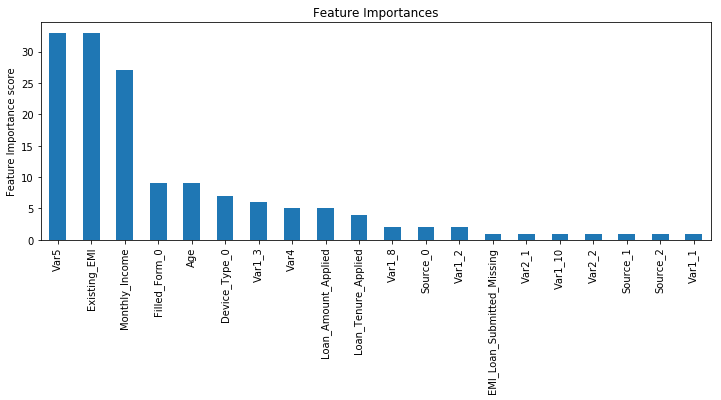

In [15]:
predictors = [x  for x in train.columns if x  not in [target, IDcol]]
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=10,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27
                    )
modelfit(xgb1, train, test, predictors)

## 对subsample 和 max_features 用grid search查找最好的参数


In [16]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_chil_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=140,
                                               max_depth=5, min_child_weight=1,
                                               gamma=0, subsample=0.8,colsample_bytree=0.8,
                                               objective='binary:logistic',nthread=4,
                                               scale_pos_weight1=1,seed=27),
                       param_grid=param_test1, scoring="roc_auc", n_jobs=4, iid=False, cv=5)
gsearch1.fit(train[predictors], train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, scale_pos_weight1=1, seed=27,
       silent=None, subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_chil_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
gsearch1.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([13.94528866, 14.20519099, 14.26303606, 19.35860214, 19.45374756,
        21.34121423, 27.44420667, 28.25499763, 55.63354187, 92.54254942,
        80.19029932, 74.17298756]),
 'std_fit_time': array([ 0.43723615,  0.31690898,  0.59444953,  0.87659578,  1.33140525,
         1.28617174,  1.59336827,  2.07254666, 13.83326545,  8.69187851,
         1.7001429 ,  0.77023596]),
 'mean_score_time': array([0.09215121, 0.08656859, 0.09534531, 0.09195409, 0.10890889,
        0.11588964, 0.13703318, 0.12586403, 0.17533069, 0.17094264,
        0.16815014, 0.1681807 ]),
 'std_score_time': array([0.01246429, 0.0093856 , 0.01757812, 0.00632044, 0.01447212,
        0.0129936 , 0.03315399, 0.01037164, 0.02912083, 0.01601478,
        0.01906588, 0.01782963]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
 

Text(87.0, 0.5, 'max_depth')

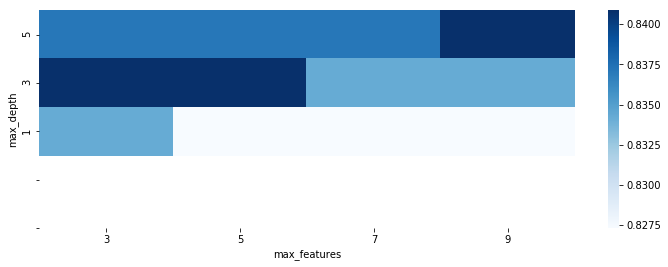

In [22]:
import seaborn as sb
grid_visualization = []
for grid_pair in gsearch1.cv_results_["mean_test_score"]:
    grid_visualization.append(grid_pair)
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (3,4)
sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4)+0.5, gsearch1.param_grid["max_depth"])
plt.yticks(np.arange(5)+0.5, gsearch1.param_grid["min_chil_weight"][::-1])
plt.xlabel("max_features")
plt.ylabel("max_depth")

##  对正则化做交叉验证

In [26]:
#  对reg_alpha用grid search寻找最合适的参数
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1,100]
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=177, max_depth=4,
                                               min_child_weight=6, gamma=.1, subsample=0.8, colsample_bytree=0.8,
                                               objective='binary:logistic', nthread=4,scale_pos_weight=1, seed=27),
                       param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch6.fit(train[predictors], train[target])


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=177, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
gsearch6.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([23.9844841 , 27.00375128, 23.06024952, 21.64102912, 16.91169887]),
 'std_fit_time': array([1.95166406, 1.35659549, 1.6130935 , 0.27579064, 4.87514195]),
 'mean_score_time': array([0.13244467, 0.12187419, 0.13164778, 0.1071135 , 0.07560868]),
 'std_score_time': array([0.02510656, 0.0205985 , 0.03258699, 0.00949475, 0.01889903]),
 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 1e-05},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.1},
  {'reg_alpha': 1},
  {'reg_alpha': 100}],
 'split0_test_score': array([0.82847047, 0.83142789, 0.83155079, 0.83111599, 0.79311027]),
 'split1_test_score': array([0.83516081, 0.83573658, 0.83729572, 0.83873504, 0.79580598]),
 'split2_test_score': array([0.84999148, 0.8514884 , 0.84936457, 0.84838652, 0.82043577]),
 'split3_test_score': array([0.84577577, 0.84667502, 0.84730349, 0.84759998,

#### 换一组参数对reg_alpha用grid search寻找最合适的参数

In [28]:
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=177, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [30]:
gsearch7.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([23.47623143, 26.09717102, 25.64266567, 23.03624158, 23.97624307]),
 'std_fit_time': array([1.31497396, 0.18017348, 0.19786423, 1.13985272, 7.29759504]),
 'mean_score_time': array([0.12845626, 0.10591688, 0.12247601, 0.12053213, 0.10876517]),
 'std_score_time': array([0.01798965, 0.01319159, 0.01595501, 0.02343401, 0.02498759]),
 'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 0},
  {'reg_alpha': 0.001},
  {'reg_alpha': 0.005},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.05}],
 'split0_test_score': array([0.82847047, 0.82847036, 0.83232642, 0.83142789, 0.83241857]),
 'split1_test_score': array([0.83516081, 0.83379489, 0.83653633, 0.83573658, 0.83427451]),
 'split2_test_score': array([0.84999148, 0.84999194, 0.84999388, 0.8514884 , 0.84924108]),
 'split3_test_score': array([0.84577565, 0.84577715, 0.84667318, 0.846


 关于这个模型
准确率: 0.9854
AUC 得分为(训练集是)：0.789831


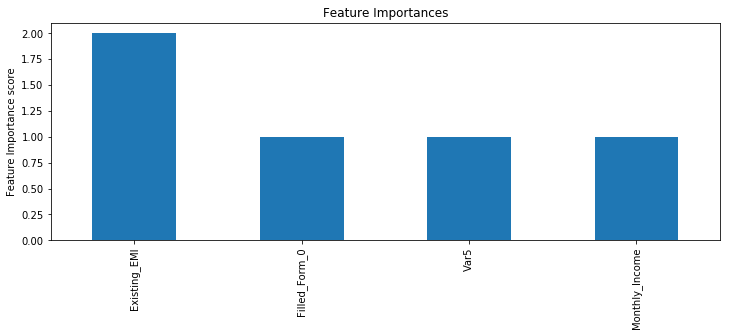

In [32]:
predictors = [x  for x in train.columns if x  not in [target, IDcol]]
xgb3 = XGBClassifier(learning_rate=0.1, n_estimators=100,
                    max_depth=4,min_child_weight=6, gamma=0,subsample=0.8,
                    colsample_bytree=0.8, reg_alpha=0.005,
                    objective='binary:logistic',nthread=4,
                    scale_pos_weight=1, seed=27)
modelfit(xgb3, train, test, predictors)


 关于这个模型
准确率: 0.9854
AUC 得分为(训练集是)：0.789831


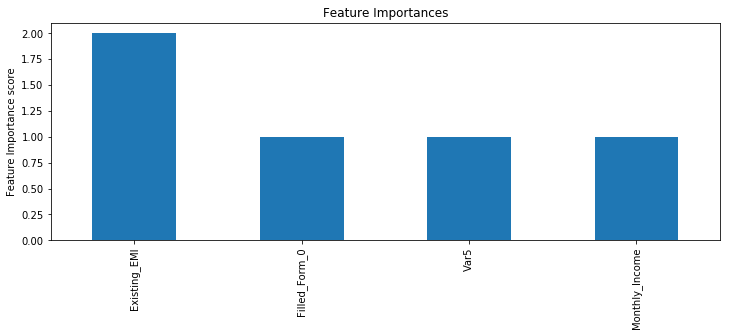

In [33]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, train, test, predictors)